# Code for competition

In [1]:
import tensorflow as tf
from keras.datasets import mnist
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)
print(tf.config.list_physical_devices())

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

2.10.0
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### Load the dataset

In [2]:
samples = []
targets = []

images_ind = [186, 532, 515, 511, 531, 222, 537, 508]
for i in range(0, len(images_ind)):
    for j in range(0, images_ind[i]):
        temp = Image.open(f'training_data_final/Species{i + 1}/{j:05}.jpg').convert('RGB')
        image = np.squeeze(np.expand_dims(temp, axis=0))
        label = tfk.utils.to_categorical(i, len(images_ind))
        samples.append(image)
        targets.append(label)

X = np.array(samples)
y = np.array(targets, dtype=np.uint8)
print(X.shape, y.shape)
print(X.dtype, y.dtype, sep=", ")

(3542, 96, 96, 3) (3542, 8)
uint8, uint8


### Models metadata

In [3]:
input_shape = X.shape[1:]
image_shape = input_shape[:-1]
batch_size = 128
epochs = 200
labels = ["Species1", "Species2", "Species3", "Species4", "Species5", "Species6", "Species7", "Species8"]

### Static augmentation

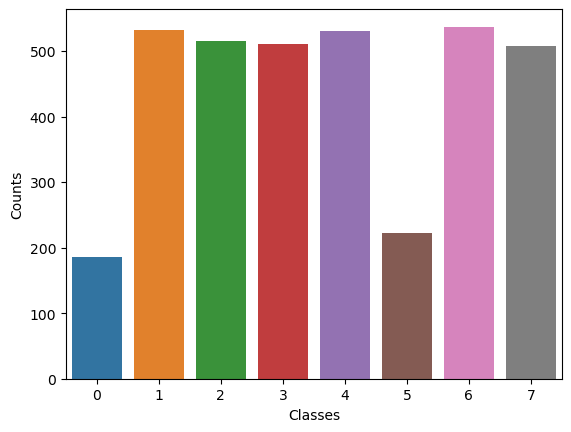

In [4]:
classes, counts = np.unique(np.fromiter([np.argmax(t) for t in y], np.int32), return_counts=True)

plt.ylabel('Counts')
plt.xlabel('Classes')
sns.barplot(x = classes, y = counts)
plt.show()

In [5]:
shift_range = 20
gen = ImageDataGenerator(rotation_range=90,  #TODO: choose the transformations
                         height_shift_range=shift_range,
                         width_shift_range=shift_range,
                         horizontal_flip=True,
                         vertical_flip=True,
                         zoom_range = 0.2,
                         fill_mode='reflect')

desired_amount = 800

ref_list = []
aug_samples = []
aug_targets = []

for i in range(0, len(labels)):
    ref_list.append([])
  
for i in range(0, len(y)):
    ref_list[np.argmax(y[i])].append(X[i])

for i in range(0, len(labels)):
    length = len(ref_list[i])
    to_produce = desired_amount - length
    target = tfk.utils.to_categorical(i, len(labels))
    print(f'Computing {to_produce} augmented images for target {i}')
    aug_targets_i = np.full((length, len(labels)), target)
    aug_gen_i = gen.flow(np.array(ref_list[i]), 
                         aug_targets_i,
                         batch_size=1,
                         seed=seed,
                         shuffle=True)
    for j in range(0, to_produce):
        aug_samples.append(np.squeeze(next(aug_gen_i)[0]))
        aug_targets.append(target)

Computing 614 augmented images for target 0
Computing 268 augmented images for target 1
Computing 285 augmented images for target 2
Computing 289 augmented images for target 3
Computing 269 augmented images for target 4
Computing 578 augmented images for target 5
Computing 263 augmented images for target 6
Computing 292 augmented images for target 7


### Test pre-processing

In [6]:
# Saturation adjustment
new_aug_samples = []
for img in aug_samples: 
    new_aug_samples.append(np.array(tf.image.adjust_saturation(img, 2)))

### Show some example of augmented images

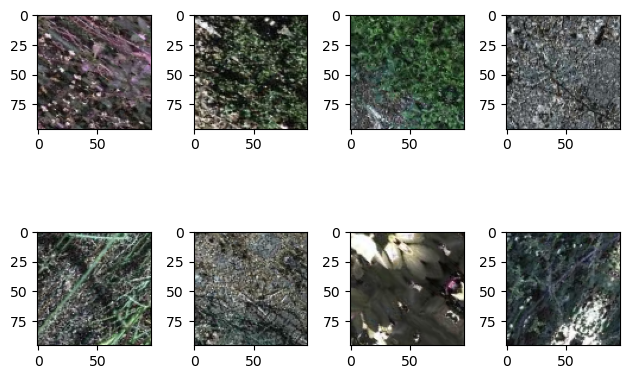

In [7]:
num_row = 2
num_col = 4
fig, axes = plt.subplots(num_row, num_col)
for i in range(num_row * num_col):

    img = random.choice(aug_samples)  # chaneg to new_aug_samples to see preprocessing effects
    ax = axes[i//num_col, i%num_col]
    ax.imshow(Image.fromarray(img.astype(np.uint8)))

plt.tight_layout()
plt.show()

### Append new samples to the original one

In [8]:
X_aug = np.concatenate((X, np.array(aug_samples, dtype=np.uint8)))
y_aug = np.concatenate((y, np.array(aug_targets, dtype=np.uint8)))
print(X_aug.shape, y_aug.shape)
print(X_aug.dtype, y_aug.dtype, sep=", ")

(6400, 96, 96, 3) (6400, 8)
uint8, uint8


### Apply pre-processing
All that is done here must be included in the pre-processing phase

In [9]:
# Saturation adjustment
temp = []
for img in X_aug: 
    temp.append(np.array(tf.image.adjust_saturation(img, 2)))

X_aug = np.array(temp)
print(X_aug.shape, X_aug.dtype, sep=", ")

(6400, 96, 96, 3), uint8


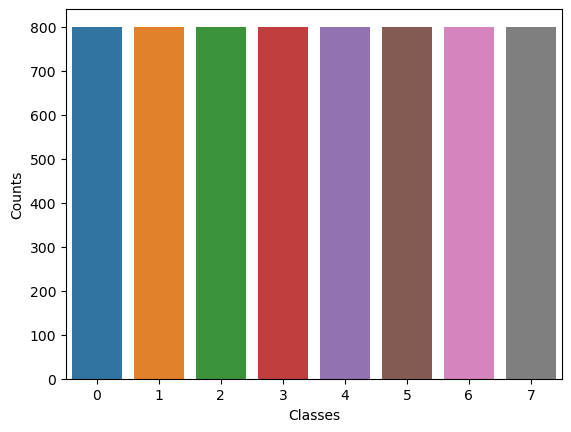

In [10]:
classes, counts = np.unique(np.fromiter([np.argmax(t) for t in y_aug], np.int32), return_counts=True)

plt.ylabel('Counts')
plt.xlabel('Classes')
sns.barplot(x = classes, y = counts)
plt.show()

### Models definition functions

In [11]:
def build_tl_model(input_shape):
    tf.random.set_seed(seed)

    #Load the supernet
    supernet = tfk.applications.VGG16(include_top=False,
                                      weights="imagenet",
                                      input_shape=input_shape)

    # Use the supernet as feature extractor
    supernet.trainable = False
    
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')
    
    x = supernet(input_layer)

    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    
    x = tfkl.Dropout(0.3, seed=seed, name='gap_dropout')(x)

    x = tfkl.Dense(
        units = 256,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'classifier_1')(x)
    
    x = tfkl.Dropout(0.3, seed=seed, name='classifier_1_dropout')(x)

    x = tfkl.Dense(
        units = 256,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'classifier_2')(x)
    
    x = tfkl.Dropout(0.3, seed=seed, name='classifier_2_dropout')(x)

    output_layer = tfkl.Dense(
        units = len(labels), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)
    
    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'tl_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model


def build_conv_model(input_shape):
    tf.random.set_seed(seed)

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    x = tfkl.Conv2D(
        filters = 64,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv1')(input_layer)
    
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(
        filters = 128,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'conv2')(x)
    
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(
        filters = 256,
        kernel_size = 3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'Conv3')(x)
    
    x = tfkl.GlobalAveragePooling2D(name='gap')(x)
    
    x = tfkl.Dropout(0.3, seed=seed, name='gap_dropout')(x)

    x = tfkl.Dense(
        units = 256,  
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed),
        name = 'classifier')(x)
    
    x = tfkl.Dropout(0.3, seed=seed, name='classifier_dropout')(x)

    output_layer = tfkl.Dense(
        units = len(labels), 
        activation = 'softmax', 
        kernel_initializer = tfk.initializers.GlorotUniform(seed),
        name = 'output_layer')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs = input_layer, outputs = output_layer, name = 'convolutional_model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

### Split the dataset (85-15)

In [12]:
X_train, X_val, y_train, y_val = train_test_split(X_aug, y_aug, stratify=y_aug, test_size=0.15)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(5440, 96, 96, 3) (5440, 8)
(960, 96, 96, 3) (960, 8)


### Define the model

In [13]:
model = build_tl_model(input_shape)
model.summary()

Model: "tl_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, 3, 3, 512)         14714688  
                                                                 
 gap (GlobalAveragePooling2D  (None, 512)              0         
 )                                                               
                                                                 
 gap_dropout (Dropout)       (None, 512)               0         
                                                                 
 classifier_1 (Dense)        (None, 256)               131328    
                                                                 
 classifier_1_dropout (Dropo  (None, 256)              0         
 ut)                                                      

### Train the model

In [14]:
# Transfer learning preprocessing (to be included in the preprocessing)
from tensorflow.keras.applications.vgg16 import preprocess_input
X_train_tl = np.array(preprocess_input(X_train), dtype=np.uint8)
X_val_tl = np.array(preprocess_input(X_val), dtype=np.uint8)

history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True)]
).history

Epoch 1/200
43/43 [==============================] - 60s 886ms/step - loss: 7.4566 - accuracy: 0.2149 - val_loss: 1.5986 - val_accuracy: 0.4156
Epoch 2/200
43/43 [==============================] - 27s 637ms/step - loss: 2.8989 - accuracy: 0.3007 - val_loss: 1.4684 - val_accuracy: 0.4448
Epoch 3/200
43/43 [==============================] - 29s 670ms/step - loss: 2.2093 - accuracy: 0.3226 - val_loss: 1.4683 - val_accuracy: 0.4594
Epoch 4/200
43/43 [==============================] - 30s 700ms/step - loss: 1.9335 - accuracy: 0.3483 - val_loss: 1.4815 - val_accuracy: 0.4719
Epoch 5/200
43/43 [==============================] - 30s 705ms/step - loss: 1.8107 - accuracy: 0.3658 - val_loss: 1.4471 - val_accuracy: 0.4969
Epoch 6/200
43/43 [==============================] - 31s 726ms/step - loss: 1.6998 - accuracy: 0.3805 - val_loss: 1.4256 - val_accuracy: 0.5271
Epoch 7/200
43/43 [==============================] - 31s 729ms/step - loss: 1.6454 - accuracy: 0.4090 - val_loss: 1.4012 - val_accuracy:

### Plot training results

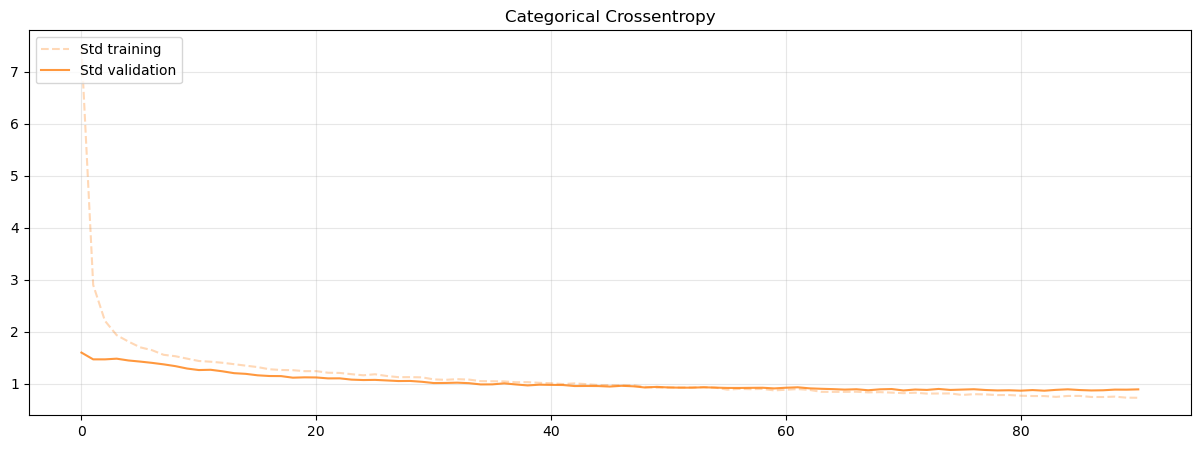

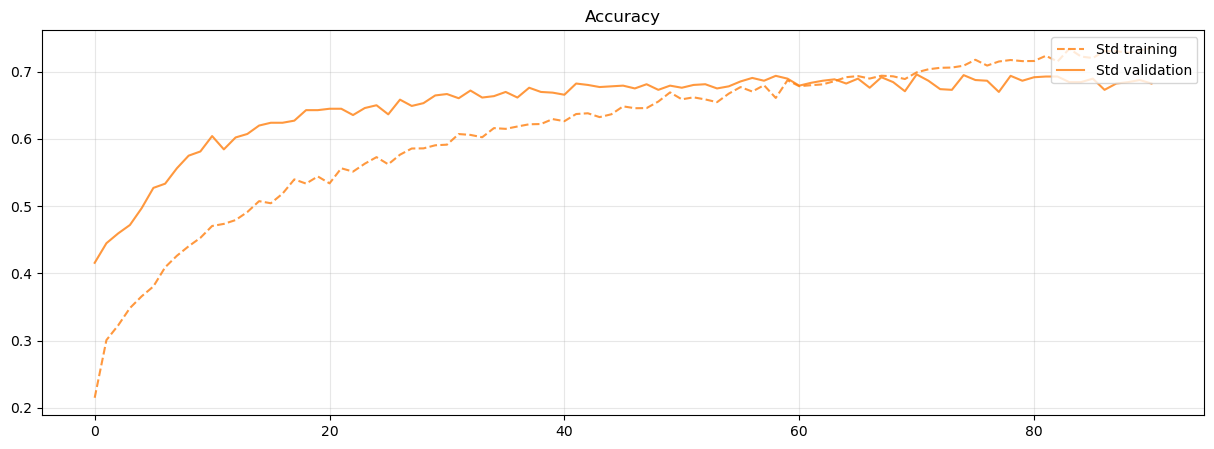

In [15]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Std training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Std training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

### Plot the confusion matrix (evaluated on the validation set)

30/30 [==============================] - 4s 129ms/step
Accuracy: 0.6958
Precision: 0.7039
Recall: 0.6958
F1: 0.6948


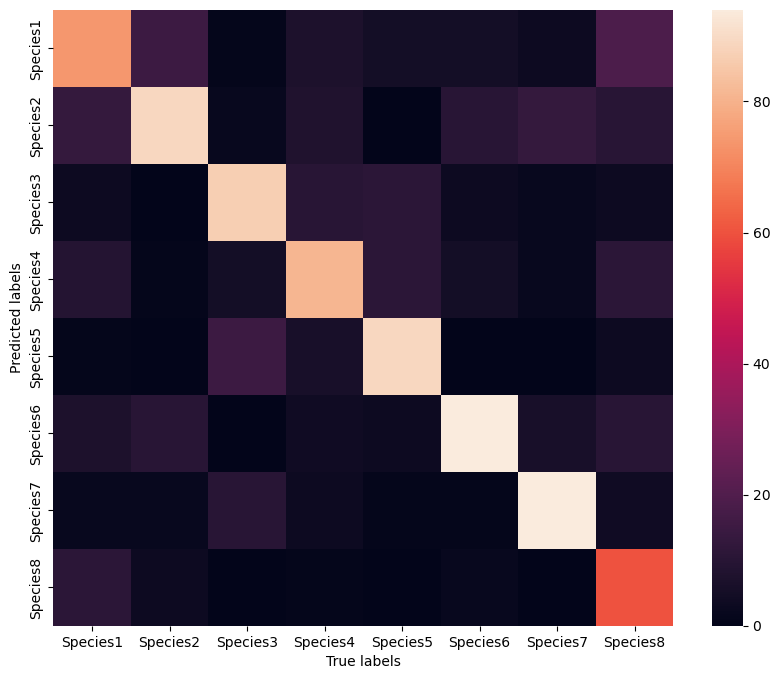

In [17]:
predictions = model.predict(X_val)
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

### Save the model

In [18]:
restored_model = tfk.models.load_model('best_model')
restored_loss, restored_acc = restored_model.evaluate(X_val, y_val, verbose=2)  #TODO: not right because validation set can change
loss, acc = model.evaluate(X_val, y_val, verbose=2)
if acc > restored_acc:  # know that this is conceptually wrong
    print("Model improved!")
    model.save('best_model')
else:
    print("No improvement!")

30/30 - 1s - loss: 3.8793 - accuracy: 0.4219 - 1s/epoch - 39ms/step
30/30 - 4s - loss: 0.8705 - accuracy: 0.6958 - 4s/epoch - 132ms/step
Model improved!


INFO:tensorflow:Assets written to: best_model\assets


INFO:tensorflow:Assets written to: best_model\assets
